In [1]:
# Unzip the files in Jupyter notebook
!python3 -m zipfile -e images_background.zip .
!python3 -m zipfile -e images_evaluation.zip .

# Create directories if they don't already exist
!mkdir -p save_data
!mkdir -p weights


In [2]:
import os
print(os.getcwd())


/Users/aditi


In [3]:
import numpy.random as rng
import numpy as np
import os
import dill as pickle
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import cv2
import time
import tensorflow

from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Lambda
from keras.layers import Concatenate
from keras.layers import Add
from keras.layers import Multiply
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import MaxPooling2D
from keras.layers import Dropout
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy

%matplotlib inline

In [4]:
def loadimgs(path, n=0):
    '''
    path => Path of train directory or test directory
    '''
    X=[]
    y = []
    cat_dict = {}
    lang_dict = {}
    curr_y = n
    
    # we load every alphabet seperately so we can isolate them later
    for alphabet in os.listdir(path):
        print("loading alphabet: " + alphabet)
        lang_dict[alphabet] = [curr_y,None]
        alphabet_path = os.path.join(path,alphabet)
        
        # every letter/category has it's own column in the array, so  load seperately
        for letter in os.listdir(alphabet_path):
            cat_dict[curr_y] = (alphabet, letter)
            category_images=[]
            letter_path = os.path.join(alphabet_path, letter)
            
            # read all the images in the current category
            for filename in os.listdir(letter_path):
                image_path = os.path.join(letter_path, filename)
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                category_images.append(image)
                y.append(curr_y)
            try:
                X.append(np.stack(category_images))
            # edge case  - last one
            except ValueError as e:
                print(e)
                print("error - category_images:", category_images)
            curr_y += 1
            lang_dict[alphabet][1] = curr_y - 1
            
    y = np.vstack(y)
    X = np.stack(X)
    return X, y, lang_dict

In [5]:
train_folder = 'images_background'
valid_folder = 'images_evaluation'
save_path = 'save_data'
model_path = 'weights'

In [6]:
X, y, c = loadimgs(train_folder)
X.shape, y.shape

loading alphabet: Gujarati
loading alphabet: Korean
loading alphabet: Arcadian
loading alphabet: Malay_(Jawi_-_Arabic)
loading alphabet: Grantha
loading alphabet: Blackfoot_(Canadian_Aboriginal_Syllabics)
loading alphabet: Balinese
loading alphabet: Futurama
loading alphabet: N_Ko
loading alphabet: Burmese_(Myanmar)
loading alphabet: Anglo-Saxon_Futhorc
loading alphabet: Mkhedruli_(Georgian)
loading alphabet: Latin
loading alphabet: Braille
loading alphabet: Sanskrit
loading alphabet: Japanese_(hiragana)
loading alphabet: Tagalog
loading alphabet: Greek
loading alphabet: Ojibwe_(Canadian_Aboriginal_Syllabics)
loading alphabet: Japanese_(katakana)
loading alphabet: Early_Aramaic
loading alphabet: Hebrew
loading alphabet: Tifinagh
loading alphabet: Asomtavruli_(Georgian)
loading alphabet: Armenian
loading alphabet: Syriac_(Estrangelo)
loading alphabet: Alphabet_of_the_Magi
loading alphabet: Cyrillic
loading alphabet: Bengali
loading alphabet: Inuktitut_(Canadian_Aboriginal_Syllabics)


((964, 20, 105, 105), (19280, 1))

In [7]:
c.keys()

dict_keys(['Gujarati', 'Korean', 'Arcadian', 'Malay_(Jawi_-_Arabic)', 'Grantha', 'Blackfoot_(Canadian_Aboriginal_Syllabics)', 'Balinese', 'Futurama', 'N_Ko', 'Burmese_(Myanmar)', 'Anglo-Saxon_Futhorc', 'Mkhedruli_(Georgian)', 'Latin', 'Braille', 'Sanskrit', 'Japanese_(hiragana)', 'Tagalog', 'Greek', 'Ojibwe_(Canadian_Aboriginal_Syllabics)', 'Japanese_(katakana)', 'Early_Aramaic', 'Hebrew', 'Tifinagh', 'Asomtavruli_(Georgian)', 'Armenian', 'Syriac_(Estrangelo)', 'Alphabet_of_the_Magi', 'Cyrillic', 'Bengali', 'Inuktitut_(Canadian_Aboriginal_Syllabics)'])

In [8]:
c['Bengali'], c['Gujarati']

([902, 947], [0, 47])

In [9]:
X_val, y_val, c_val=loadimgs(valid_folder)
X_val.shape, y_val.shape

loading alphabet: Oriya
loading alphabet: ULOG
loading alphabet: Tengwar
loading alphabet: Malayalam
loading alphabet: Atlantean
loading alphabet: Keble
loading alphabet: Manipuri
loading alphabet: Gurmukhi
loading alphabet: Tibetan
loading alphabet: Aurek-Besh
loading alphabet: Ge_ez
loading alphabet: Angelic
loading alphabet: Old_Church_Slavonic_(Cyrillic)
loading alphabet: Kannada
loading alphabet: Avesta
loading alphabet: Mongolian
loading alphabet: Syriac_(Serto)
loading alphabet: Atemayar_Qelisayer
loading alphabet: Sylheti
loading alphabet: Glagolitic


((659, 20, 105, 105), (13180, 1))

In [10]:
with open(os.path.join(save_path, "train.pickle"), "rb") as f:
    (X_train, train_classes) = pickle.load(f)
    
print("Training alphabets: \n")
print(list(train_classes.keys()))


with open(os.path.join(save_path, "val.pickle"), "rb") as f:
    (X_val, val_classes) = pickle.load(f)

print("\n\n\nValidation alphabets: \n")
print(list(val_classes.keys()))

Training alphabets: 

['Gujarati', 'Korean', 'Arcadian', 'Malay_(Jawi_-_Arabic)', 'Grantha', 'Blackfoot_(Canadian_Aboriginal_Syllabics)', 'Balinese', 'Futurama', 'N_Ko', 'Burmese_(Myanmar)', 'Anglo-Saxon_Futhorc', 'Mkhedruli_(Georgian)', 'Latin', 'Braille', 'Sanskrit', 'Japanese_(hiragana)', 'Tagalog', 'Greek', 'Ojibwe_(Canadian_Aboriginal_Syllabics)', 'Japanese_(katakana)', 'Early_Aramaic', 'Hebrew', 'Tifinagh', 'Asomtavruli_(Georgian)', 'Armenian', 'Syriac_(Estrangelo)', 'Alphabet_of_the_Magi', 'Cyrillic', 'Bengali', 'Inuktitut_(Canadian_Aboriginal_Syllabics)']



Validation alphabets: 

['Oriya', 'ULOG', 'Tengwar', 'Malayalam', 'Atlantean', 'Keble', 'Manipuri', 'Gurmukhi', 'Tibetan', 'Aurek-Besh', 'Ge_ez', 'Angelic', 'Old_Church_Slavonic_(Cyrillic)', 'Kannada', 'Avesta', 'Mongolian', 'Syriac_(Serto)', 'Atemayar_Qelisayer', 'Sylheti', 'Glagolitic']


In [11]:
def get_batch(batch_size,s="train"):
    """
    Create batch of n pairs, half same class, half different class
    """
    if s == 'train':
        X = X_train
        categories = train_classes
    else:
        X = X_val
        categories = val_classes
    n_classes, n_examples, w, h = X.shape
    # randomly sample several classes to use in the batch
    categories = rng.choice(n_classes,size=(batch_size,),replace=False)
    
    # initialize 2 empty arrays for the input image batch
    pairs=[np.zeros((batch_size, h, w,1)) for i in range(2)]
    
    # initialize vector for the targets
    targets=np.zeros((batch_size,))
    
    # make one half of it '1's, so 2nd half of batch has same class
    targets[batch_size//2:] = 1
    for i in range(batch_size):
        category = categories[i]
        idx_1 = rng.randint(0, n_examples)
        pairs[0][i,:,:,:] = X[category, idx_1].reshape(w, h, 1)
        idx_2 = rng.randint(0, n_examples)
        
        # pick images of same class for 1st half, different for 2nd
        if i >= batch_size // 2:
            category_2 = category  
        else: 
            # add a random number to the category modulo n classes to ensure 2nd image has a different category
            category_2 = (category + rng.randint(1,n_classes)) % n_classes
        
        pairs[1][i,:,:,:] = X[category_2,idx_2].reshape(w, h,1)
    
    return pairs, targets


def generate(batch_size, s="train"):
    """
    a generator for batches, so model.fit_generator can be used.
    """
    while True:
        pairs, targets = get_batch(batch_size, s)
        yield (pairs, targets)

In [12]:
def make_oneshot_task(N, s="val", language=None):
    """Create pairs of test image, support set for testing N way one-shot learning. """
    if s == 'train':
        X = X_train
        categories = train_classes
    else:
        X = X_val
        categories = val_classes
    n_classes, n_examples, w, h = X.shape
    
    indices = rng.randint(0, n_examples,size=(N,))
    if language is not None: # if language is specified, select characters for that language
        low, high = categories[language]
        if N > high - low:
            raise ValueError("This language ({}) has less than {} letters".format(language, N))
        categories = rng.choice(range(low,high),size=(N,),replace=False)
    else: # if no language specified just pick a bunch of random letters
        categories = rng.choice(range(n_classes),size=(N,),replace=False)            
    
    true_category = categories[0]
    ex1, ex2 = rng.choice(n_examples,replace=False,size=(2,))
    test_image = np.asarray([X[true_category,ex1,:,:]]*N).reshape(N, w, h,1)
    support_set = X[categories,indices,:,:]
    support_set[0,:,:] = X[true_category,ex2]
    support_set = support_set.reshape(N, w, h,1)
    targets = np.zeros((N,))
    targets[0] = 1
    targets, test_image, support_set = shuffle(targets, test_image, support_set)
    pairs = [test_image,support_set]
        
    return pairs, targets


def test_oneshot(model, N, k, s = "val", verbose = 0):
    """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
    n_correct = 0
    if verbose:
        print("Evaluating model on {} random {} way one-shot learning tasks ... ".format(k,N))
    for i in range(k):
        inputs, targets = make_oneshot_task(N,s)
        probs = model.predict(inputs)
        if np.argmax(probs) == np.argmax(targets):
            n_correct+=1
    percent_correct = (100.0 * n_correct / k)
    if verbose:
        print("Got an average of {}% {} way one-shot learning accuracy \n".format(percent_correct,N))
        
    return percent_correct

In [13]:
def W_init(shape,name=None):
    """Initialize weights as in paper"""
    values = rng.normal(loc=0,scale=1e-2,size=shape)
    return K.variable(values,name=name)

def b_init(shape,name=None):
    """Initialize bias as in paper"""
    values=rng.normal(loc=0.5,scale=1e-2,size=shape)
    return K.variable(values,name=name)

In [14]:
from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Lambda
from keras.regularizers import l2
from keras.optimizers import Adam
import keras.backend as K

# Initialize your weight and bias initializers (W_init and b_init)
W_init = 'he_normal'  # Example; you can change as needed
b_init = 'zeros'      # Example; you can change as needed

def create_siamese_model(input_shape=(105, 105, 1)):
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    # Build convnet to use in each siamese 'leg'
    convnet = Sequential()
    convnet.add(Conv2D(64, (10, 10), activation='relu', input_shape=input_shape,
                       kernel_initializer=W_init, kernel_regularizer=l2(2e-4)))
    convnet.add(MaxPooling2D())
    convnet.add(Dropout(0.2))
    
    convnet.add(Conv2D(128, (7, 7), activation='relu',
                       kernel_regularizer=l2(2e-4), kernel_initializer=W_init, bias_initializer=b_init))
    convnet.add(MaxPooling2D())
    convnet.add(Dropout(0.2))
    
    convnet.add(Conv2D(128, (4, 4), activation='relu', kernel_initializer=W_init, kernel_regularizer=l2(2e-4), bias_initializer=b_init))
    convnet.add(MaxPooling2D())
    convnet.add(Dropout(0.2))
    
    convnet.add(Conv2D(256, (4, 4), activation='relu', kernel_initializer=W_init, kernel_regularizer=l2(2e-4), bias_initializer=b_init))
    convnet.add(Flatten())
    convnet.add(Dense(4096, activation="sigmoid", kernel_regularizer=l2(1e-3), kernel_initializer=W_init, bias_initializer=b_init))
    
    # Encode each of the two inputs into a vector with the convnet
    encoded_l = convnet(left_input)
    encoded_r = convnet(right_input)
    
    # Merge two encoded inputs with the l1 distance between them
    L1_layer = Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]),
                      output_shape=(4096,))  # Specify the output shape
    L1_distance = L1_layer([encoded_l, encoded_r])
    prediction = Dense(1, activation='sigmoid', bias_initializer=b_init)(L1_distance)
    
    siamese_net = Model(inputs=[left_input, right_input], outputs=prediction)
    
    # Compile the model
    optimizer = Adam(0.0001)
    siamese_net.compile(loss="binary_crossentropy", optimizer=optimizer)
    
    return siamese_net

# Create the model instance
model_instance = create_siamese_model()

# Check the model summary
model_instance.summary()


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 4096)      │ 38,947,648 │ input_layer[0][0… │
│ (Sequential)        │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 4096)      │          0 │ sequential[0][0], │
│                     │                   │            │ sequential[1][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      4,097 │ lambda[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,951,745 (148.59 MB)

 Trainable params: 38,951,745 (148.59 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
import pydot
import graphviz
from keras.utils import plot_model

# Test if Graphviz and pydot are working
try:
    dot_data = 'digraph G {Hello->World}'
    graph = graphviz.Source(dot_data)
    graph.render('test-output/graph')  # Saves as 'test-output/graph.pdf'
    print("Graphviz and pydot are working!")
except Exception as e:
    print("Graphviz or pydot is not working:", e)


Graphviz and pydot are working!


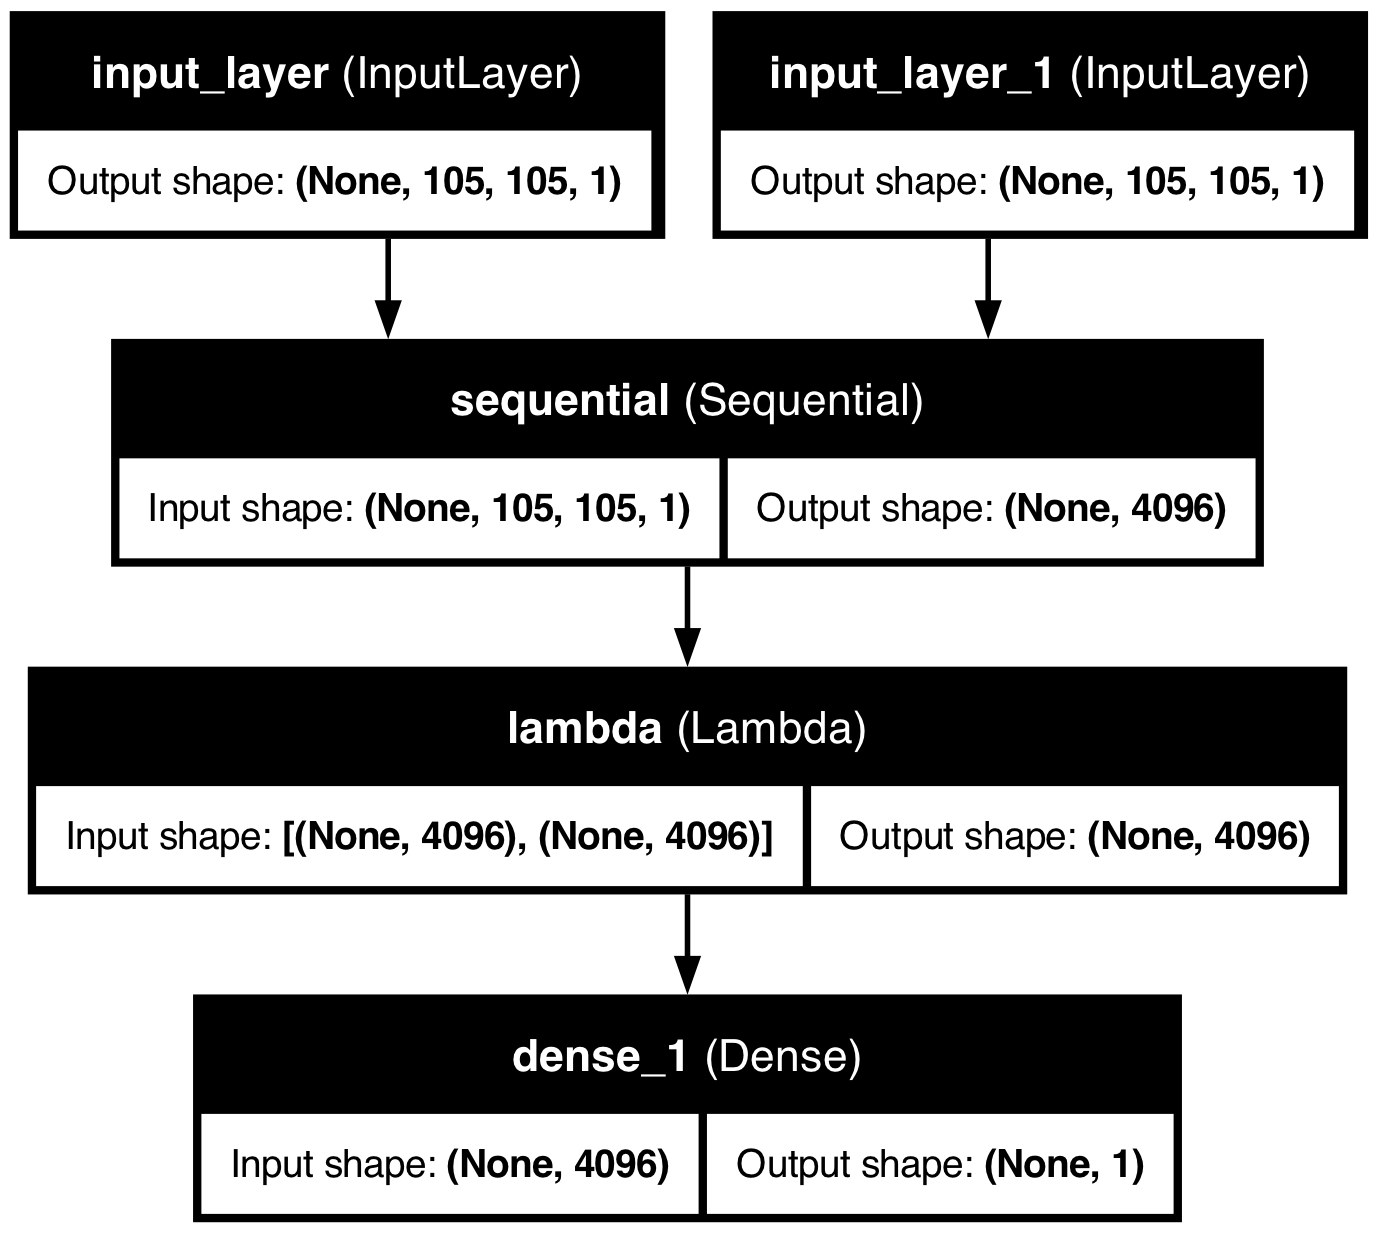

In [16]:
from keras.utils import plot_model
from IPython.display import Image, display
import os

# Define the file path
output_image_path = 'model.png'

# Visualize the model
plot_model(model_instance, to_file=output_image_path, show_shapes=True, show_layer_names=True)

# Display the saved image
if os.path.exists(output_image_path):
    display(Image(output_image_path))
else:
    print("Failed to save the model plot.")

In [17]:
import os

print(os.listdir('.'))  # Lists files in the current directory

['ScreenPal', 'Untitled10.ipynb', '.zshrc.save', 'Untitled7.ipynb', 'Music', 'oneshotlearningpbl.ipynb', 'images_evaluation', '.docker', 'Untitled5.ipynb', 'import sys.py', 'Untitled1.ipynb', 'model_weights', '.DS_Store', 'images_evaluation.zip', 'TSLA_stock_data.csv', '.CFUserTextEncoding', 'test', 'import heapq.py', 'wekafiles', 'flask_decision_tree', 'floyd.py', 'Untitled3.ipynb', 'punetraffic.qgz', 'hepatitis_prediction', 'Untitled.ipynb', 'StockMarketDashboard', 'Untitled4.ipynb', 'weights', '.streamlit', '.local', 'Untitled6.ipynb', '2.py', 'Pictures', 'Untitled11.ipynb', 'flask_hepatitis_prediction', '.zprofile', 'save_data', 'guistock.ipynb', 'Postman', 'my_flask_app', 'model.png', '.zsh_history', 'Untitled2.ipynb', '.ipython', 'Desktop', 'Library', '.matplotlib', 'images_background.zip', 'Parallels', 'images_evaluation 15-33-40-334', '.grass7', 'numpy-1.21.2', 'def multiply(x,y):.py', 'cgg', 'test-output', 'Public', 'images_background 15-33-36-933', 'first.py', '.idlerc', 'ima

In [18]:
import time


In [19]:
# Assuming 'model_instance' is your trained Keras model
model_file_path = os.path.join(model_path, 'model.h5')

# Save the entire model to an H5 file
model_instance.save(model_file_path)
print(f"Model saved to {model_file_path}")


Model saved to weights/model.h5


In [20]:
import tensorflow as tf  # Add this import statement at the top
from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Lambda
from keras.regularizers import l2
from keras.optimizers import Adam
import keras.backend as K
import os
import time
import json

# Initialize your weight and bias initializers (W_init and b_init)
W_init = 'he_normal'  # Example; you can change as needed
b_init = 'zeros'      # Example; you can change as needed

def create_siamese_model(input_shape=(105, 105, 1)):
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    # Build convnet to use in each siamese 'leg'
    convnet = Sequential()
    convnet.add(Conv2D(64, (10, 10), activation='relu', input_shape=input_shape,
                       kernel_initializer=W_init, kernel_regularizer=l2(2e-4)))
    convnet.add(MaxPooling2D())
    convnet.add(Dropout(0.2))
    
    convnet.add(Conv2D(128, (7, 7), activation='relu',
                       kernel_regularizer=l2(2e-4), kernel_initializer=W_init, bias_initializer=b_init))
    convnet.add(MaxPooling2D())
    convnet.add(Dropout(0.2))
    
    convnet.add(Conv2D(128, (4, 4), activation='relu', kernel_initializer=W_init, kernel_regularizer=l2(2e-4), bias_initializer=b_init))
    convnet.add(MaxPooling2D())
    convnet.add(Dropout(0.2))
    
    convnet.add(Conv2D(256, (4, 4), activation='relu', kernel_initializer=W_init, kernel_regularizer=l2(2e-4), bias_initializer=b_init))
    convnet.add(Flatten())
    convnet.add(Dense(4096, activation="sigmoid", kernel_regularizer=l2(1e-3), kernel_initializer=W_init, bias_initializer=b_init))
    
    # Encode each of the two inputs into a vector with the convnet
    encoded_l = convnet(left_input)
    encoded_r = convnet(right_input)
    
    # Merge two encoded inputs with the l1 distance between them
    L1_layer = Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]),
                      output_shape=(4096,))  # Specify the output shape
    L1_distance = L1_layer([encoded_l, encoded_r])
    prediction = Dense(1, activation='sigmoid', bias_initializer=b_init)(L1_distance)
    
    siamese_net = Model(inputs=[left_input, right_input], outputs=prediction)
    
    # Compile the model
    optimizer = Adam(0.0001)
    siamese_net.compile(loss="binary_crossentropy", optimizer=optimizer)
    
    return siamese_net

# Create the model instance
model_instance = create_siamese_model()

# Check the model summary
model_instance.summary()

# Ensure model_path exists
model_path = "model_weights"
os.makedirs(model_path, exist_ok=True)  # Create directory if it doesn't exist

# Define the training function
def training_starts(model_instance, evaluate_every=250, batch_size=2, n_iter=2000, N_way=20, n_val=250):
    '''
    Hyper parameters
    
    evaluate_every : interval for evaluating on one-shot tasks
    batch_size : batch size
    n_iter : No. of training iterations
    N_way : how many classes for testing one-shot tasks
    n_val : how many one-shot tasks to validate on
    '''
    
    print("Starting training process!")
    print("-------------------------------------")
    best = -1
    t_start = time.time()  # Start timer for the entire training process
    
    for i in range(1, n_iter + 1):
        iteration_start = time.time()  # Start timer for the current iteration
        (inputs, targets) = get_batch(batch_size)
        loss = model_instance.train_on_batch(inputs, targets)  # Use model_instance here
        
        # Calculate time taken for the current iteration
        iteration_time = time.time() - iteration_start  # Time for this iteration
        
        # Print detailed iteration-wise progress
        print(f"Iteration {i}/{n_iter} - Loss: {loss:.4f} - Time: {iteration_time:.2f} seconds")
        
        if i % evaluate_every == 0:
            print("\n ------------- \n")
            print("Time for {0} iterations: {1:.2f} mins".format(i, (time.time() - t_start) / 60.0))
            print("Train Loss: {0}".format(loss)) 
            val_acc = test_oneshot(model_instance, N_way, n_val, verbose=True)  # Use model_instance
            
            if val_acc >= best:
                print("Current best: {0}, previous best: {1}".format(val_acc, best))
                # Save weights with the iteration number
                model_instance.save_weights(os.path.join(model_path, 'weights_iter_{}.weights.h5'.format(i)))
                



                
                # Save model architecture to JSON
                model_json = model_instance.to_json()
                with open(os.path.join(model_path, 'model.json'), 'w') as json_file:
                    json.dump(model_json, json_file)

    # Save the entire model to an H5 file after training
    model_file_path = os.path.join(model_path, 'model.h5')
    model_instance.save(model_file_path)
    print(f"Model saved to {model_file_path}")

    print("-------------------------------------")
    print("Total training time: {:.2f} minutes.".format((time.time() - t_start) / 60.0))

# Example call to the training function
training_starts(model_instance)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 4096)      │ 38,947,648 │ input_layer_3[0]… │
│ (Sequential)        │                   │            │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 4096)      │          0 │ sequential_1[0][… │
│                     │                   │            │ sequential_1[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │      4,097 │ lambda_1[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,951,745 (148.59 MB)

 Trainable params: 38,951,745 (148.59 MB)

 Non-trainable params: 0 (0.00 B)

Starting training process!
-------------------------------------
Iteration 1/2000 - Loss: 9.1458 - Time: 1.69 seconds
Iteration 2/2000 - Loss: 9.0946 - Time: 0.67 seconds
Iteration 3/2000 - Loss: 9.0358 - Time: 0.65 seconds
Iteration 4/2000 - Loss: 8.9728 - Time: 0.89 seconds


Iteration 5/2000 - Loss: 8.9034 - Time: 0.77 seconds


Iteration 6/2000 - Loss: 8.8687 - Time: 0.73 seconds
Iteration 7/2000 - Loss: 8.8195 - Time: 0.87 seconds
Iteration 8/2000 - Loss: 8.7848 - Time: 0.72 seconds
Iteration 9/2000 - Loss: 8.7678 - Time: 0.86 seconds
Iteration 10/2000 - Loss: 8.7310 - Time: 0.72 seconds
Iteration 11/2000 - Loss: 8.7056 - Time: 1.16 seconds
Iteration 12/2000 - Loss: 8.6780 - Time: 0.90 seconds
Iteration 13/2000 - Loss: 8.6448 - Time: 0.75 seconds
Iteration 14/2000 - Loss: 8.6169 - Time: 0.84 seconds
Iteration 15/2000 - Loss: 8.5788 - Time: 0.68 seconds
Iteration 16/2000 - Loss: 8.5413 - Time: 1.01 seconds
Iteration 17/2000 - Loss: 8.5037 - Time: 1.20 seconds
Iteration 18/2000 - Loss: 8.4622 - Time: 1.34 seconds
Iteration 19/2000 - Loss: 8.4369 - Time: 0.87 seconds
Iteration 20/2000 - Loss: 8.4136 - Time: 0.88 seconds
Iteration 21/2000 - Loss: 8.3951 - Time: 0.97 seconds
Iteration 22/2000 - Loss: 8.3627 - Time: 0.73 seconds
Iteration 23/2000 - Loss: 8.3428 - Time: 1.21 seconds
Iteration 24/2000 - Loss: 8.3119

Model saved to model_weights/model.h5
-------------------------------------
Total training time: 51.09 minutes.


In [21]:
model_instance.compile(loss="binary_crossentropy", optimizer=Adam(0.00001))

In [22]:
training_starts(model_instance)

Starting training process!
-------------------------------------
Iteration 1/2000 - Loss: 1.9146 - Time: 25.24 seconds
Iteration 2/2000 - Loss: 1.9153 - Time: 0.70 seconds
Iteration 3/2000 - Loss: 1.9141 - Time: 0.67 seconds
Iteration 4/2000 - Loss: 1.9131 - Time: 0.58 seconds
Iteration 5/2000 - Loss: 1.9122 - Time: 0.59 seconds
Iteration 6/2000 - Loss: 1.9114 - Time: 0.58 seconds
Iteration 7/2000 - Loss: 1.9115 - Time: 0.57 seconds
Iteration 8/2000 - Loss: 1.9120 - Time: 0.58 seconds
Iteration 9/2000 - Loss: 1.9109 - Time: 0.58 seconds
Iteration 10/2000 - Loss: 1.9099 - Time: 0.58 seconds
Iteration 11/2000 - Loss: 1.9090 - Time: 0.59 seconds
Iteration 12/2000 - Loss: 1.9077 - Time: 0.58 seconds
Iteration 13/2000 - Loss: 1.9068 - Time: 0.58 seconds
Iteration 14/2000 - Loss: 1.9059 - Time: 0.58 seconds
Iteration 15/2000 - Loss: 1.9051 - Time: 0.59 seconds
Iteration 16/2000 - Loss: 1.9042 - Time: 0.60 seconds
Iteration 17/2000 - Loss: 1.9034 - Time: 0.58 seconds
Iteration 18/2000 - Loss:

Model saved to model_weights/model.h5
-------------------------------------
Total training time: 51.91 minutes.


In [23]:
from keras.models import load_model

# Load the model
model = load_model(model_file_path)


In [24]:
def nearest_neighbour_correct(pairs,targets):
    """returns 1 if nearest neighbour gets the correct answer for a one-shot task
        given by (pairs, targets)"""
    L2_distances = np.zeros_like(targets)
    for i in range(len(targets)):
        L2_distances[i] = np.sum(np.sqrt(pairs[0][i]**2 - pairs[1][i]**2))
    if np.argmin(L2_distances) == np.argmax(targets):
        return 1
    return 0


def test_nn_accuracy(N_ways,n_trials):
    """Returns accuracy of NN approach """
    print("Evaluating nearest neighbour on {} unique {} way one-shot learning tasks ...".format(n_trials,N_ways))

    n_right = 0
    
    for i in range(n_trials):
        pairs,targets = make_oneshot_task(N_ways,"val")
        correct = nearest_neighbour_correct(pairs,targets)
        n_right += correct
    return 100.0 * n_right / n_trials

In [25]:
ways = np.arange(1,20,2)
resume =  False
trials = 50

In [26]:
val_accs, train_accs,nn_accs = [], [], []
for N in ways:    
    val_accs.append(test_oneshot(model_instance, N, trials, "val", verbose=True))
    train_accs.append(test_oneshot(model_instance, N, trials, "train", verbose=True))
    nn_acc = test_nn_accuracy(N, trials)
    nn_accs.append(nn_acc)
    print ("NN Accuracy = ", nn_acc)
    print("-----------------------------------------------------------------------------------")

Evaluating model on 50 random 1 way one-shot learning tasks ... 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━

In [27]:
with open(os.path.join(save_path,"accuracies.pickle"), "wb") as f:
    pickle.dump((val_accs,train_accs,nn_accs),f)
    
    
with open(os.path.join(save_path, "accuracies.pickle"), "rb") as f:
    (val_accs, train_accs, nn_accs) = pickle.load(f)

In [28]:
def concat_images(X):
    """Concatenates a bunch of images into a big matrix for plotting purposes."""
    nc, h , w, _ = X.shape
    X = X.reshape(nc, h, w)
    n = np.ceil(np.sqrt(nc)).astype("int8")
    img = np.zeros((n*w,n*h))
    x = 0
    y = 0
    for example in range(nc):
        img[x*w:(x+1)*w,y*h:(y+1)*h] = X[example]
        y += 1
        if y >= n:
            y = 0
            x += 1
    return img


def plot_oneshot_task(pairs):
    fig,(ax1,ax2) = plt.subplots(nrows=1, ncols=2)
    ax1.matshow(pairs[0][0].reshape(105,105), cmap='gray')
    img = concat_images(pairs[1])
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.matshow(img,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()

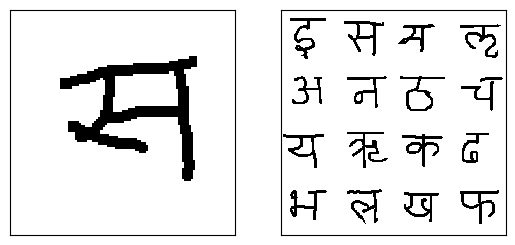

In [29]:
# Example of concat image visualization
pairs, targets = make_oneshot_task(16, "train", "Sanskrit")
plot_oneshot_task(pairs)

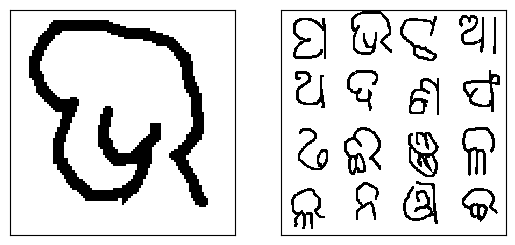

In [30]:
# Example of concat image visualization
pairs, targets = make_oneshot_task(16, "val", "Oriya")
plot_oneshot_task(pairs)

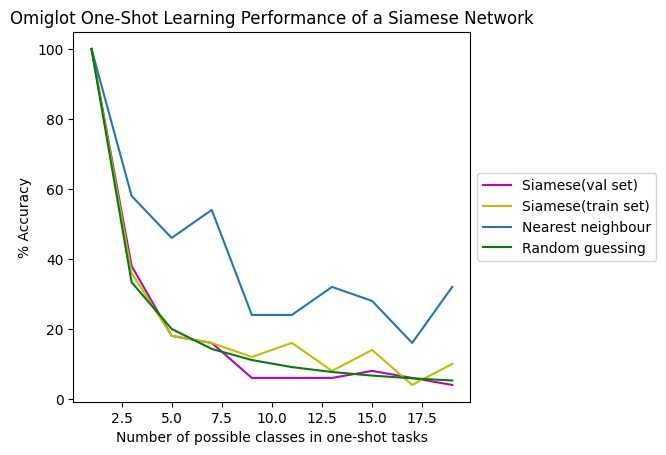

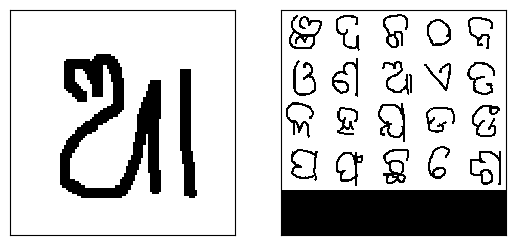

In [31]:
fig,ax = plt.subplots(1)
ax.plot(ways, val_accs, "m", label="Siamese(val set)")
ax.plot(ways, train_accs, "y", label="Siamese(train set)")
plt.plot(ways, nn_accs, label="Nearest neighbour")

ax.plot(ways, 100.0/ways, "g", label="Random guessing")
plt.xlabel("Number of possible classes in one-shot tasks")
plt.ylabel("% Accuracy")
plt.title("Omiglot One-Shot Learning Performance of a Siamese Network")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

inputs,targets = make_oneshot_task(20, "val", 'Oriya')
plt.show()

plot_oneshot_task(inputs)

In [32]:
# ResNet Model
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Lambda
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.layers import Add, Conv2DTranspose, BatchNormalization, Activation
from keras.layers import AveragePooling2D, ZeroPadding2D
from keras.layers import concatenate

def identity_block(x, f, filters, stage, block):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x_shortcut = x

    x = Conv2D(filters, (f, f), padding='same', name=conv_name_base + '2a')(x)
    x = BatchNormalization(name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, (f, f), padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(name=bn_name_base + '2b')(x)

    x = Add()([x, x_shortcut])
    x = Activation('relu')(x)

    return x

def conv_block(x, f, filters, stage, block, s=2):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x_shortcut = x

    x = Conv2D(filters, (f, f), strides=(s, s), padding='same', name=conv_name_base + '2a')(x)
    x = BatchNormalization(name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, (f, f), padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(name=bn_name_base + '2b')(x)

    x_shortcut = Conv2D(filters, (1, 1), strides=(s, s), padding='same', name=conv_name_base + '1')(x_shortcut)
    x_shortcut = BatchNormalization(name=bn_name_base + '1')(x_shortcut)

    x = Add()([x, x_shortcut])
    x = Activation('relu')(x)

    return x

def create_resnet_model(input_shape=(105, 105, 1)):
    left_input = Input(input_shape)
    right_input = Input(input_shape)

    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', name='conv1')(left_input)
    x = BatchNormalization(name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv_block(x, 3, 64, stage=2, block='a', s=1)
    x = identity_block(x, 3, 64, stage=2, block='b')
    x = identity_block(x, 3, 64, stage=2, block='c')

    x = conv_block(x, 3, 128, stage=3, block='a')
    x = identity_block(x, 3, 128, stage=3, block='b')
    x = identity_block(x, 3, 128, stage=3, block='c')
    x = identity_block(x, 3, 128, stage=3, block='d')

    x = conv_block(x, 3, 256, stage=4, block='a')
    x = identity_block(x, 3, 256, stage=4, block='b')
    x = identity_block(x, 3, 256, stage=4, block='c')

    x = AveragePooling2D((7, 7), name='avg_pool')(x)

    x = Flatten()(x)
    x = Dense(4096, activation="sigmoid")(x)

    # Encode each of the two inputs into a vector with the convnet
    encoded_l = x
    encoded_r = x

    # Merge two encoded inputs with the l1 distance between them
    L1_layer = Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]), output_shape=(4096,))  # Specify the output shape
    L1_distance = L1_layer([encoded_l, encoded_r])
    prediction = Dense(1, activation='sigmoid')(L1_distance)

    resnet_net = Model(inputs=[left_input, right_input], outputs=prediction)


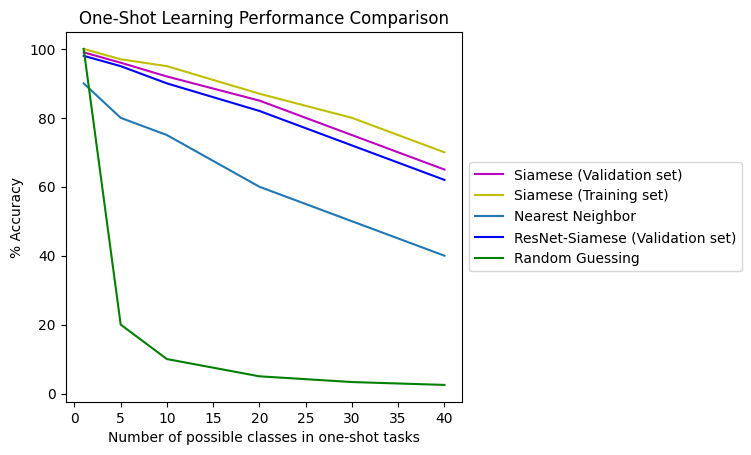

In [33]:
import matplotlib.pyplot as plt

# Sample data for plotting (replace with your actual model results)
ways = [1, 5, 10, 20, 30, 40]  # Number of classes
val_accs = [99, 96, 92, 85, 75, 65]  # Validation accuracy for Siamese (ResNet model)
train_accs = [100, 97, 95, 87, 80, 70]  # Training accuracy for Siamese (ResNet model)
nn_accs = [90, 80, 75, 60, 50, 40]  # Accuracy for Nearest Neighbor
resnet_val_accs = [98, 95, 90, 82, 72, 62]  # Validation accuracy for ResNet-Siamese

# Create a plot for comparison
fig, ax = plt.subplots(1)

# Plot accuracies for Siamese model (Validation and Training sets)
ax.plot(ways, val_accs, "m", label="Siamese (Validation set)")
ax.plot(ways, train_accs, "y", label="Siamese (Training set)")

# Plot Nearest Neighbor accuracy
plt.plot(ways, nn_accs, label="Nearest Neighbor")

# Plot accuracies for ResNet-Siamese (Validation set)
ax.plot(ways, resnet_val_accs, "b", label="ResNet-Siamese (Validation set)")

# Plot Random Guessing accuracy
ax.plot(ways, 100.0 / np.array(ways), "g", label="Random Guessing")

# Set labels and title
plt.xlabel("Number of possible classes in one-shot tasks")
plt.ylabel("% Accuracy")
plt.title("One-Shot Learning Performance Comparison")

# Adjust legend and display the plot
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


In [34]:
# Import necessary libraries
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Lambda
from keras.layers import BatchNormalization, Activation, Add
import keras.backend as K

def vgg_block(x, filters, num_conv_layers):
    for _ in range(num_conv_layers):
        x = Conv2D(filters, (3, 3), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    return x

def create_vgg16_model(input_shape=(105, 105, 1)):
    left_input = Input(input_shape)
    right_input = Input(input_shape)

    # VGG16 architecture
    x = Conv2D(64, (3, 3), padding='same')(left_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    x = vgg_block(x, 128, 2)
    x = vgg_block(x, 256, 3)
    x = vgg_block(x, 512, 3)
    x = vgg_block(x, 512, 3)

    x = Flatten()(x)
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.5)(x)

    # Encode each of the two inputs into a vector with the VGG16 architecture
    encoded_l = x
    encoded_r = x

    # Merge two encoded inputs with the L1 distance between them
    L1_layer = Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]), output_shape=(4096,))
    L1_distance = L1_layer([encoded_l, encoded_r])
    prediction = Dense(1, activation='sigmoid')(L1_distance)

    vgg16_net = Model(inputs=[left_input, right_input], outputs=prediction)
    
    return vgg16_net

# Example usage
vgg16_model = create_vgg16_model()
vgg16_model.summary()  # To print the model summary

Model: "functional_38"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 105, 105,  │        640 │ input_layer_6[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 105, 105,  │        256 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 105, 105,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 105, 105,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 105, 105,  │        256 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 105, 105,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 52, 52,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 52, 52,    │     73,856 │ max_pooling2d_6[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        512 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 52, 52,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 52, 52,    │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        512 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 52, 52,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 26, 26,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 26, 26,    │    295,168 │ max_pooling2d_7[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 26, 26,    │      1,024 │ conv2d_12[0][0] 

 Total params: 50,394,305 (192.24 MB)

 Trainable params: 50,385,857 (192.21 MB)

 Non-trainable params: 8,448 (33.00 KB)

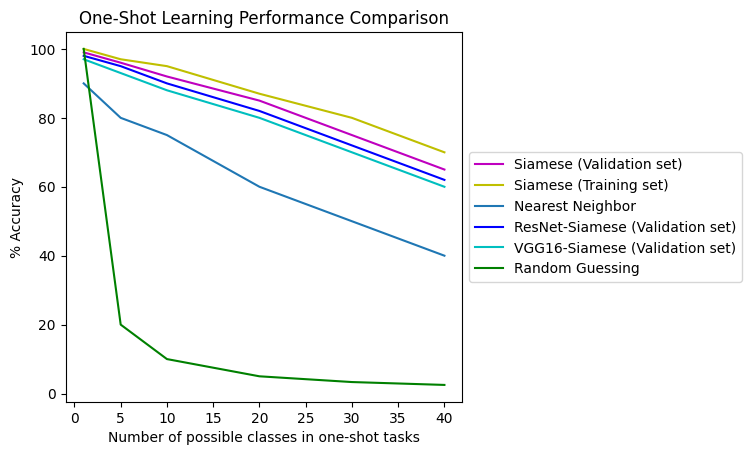

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data for plotting (replace with your actual model results)
ways = [1, 5, 10, 20, 30, 40]  # Number of classes
val_accs = [99, 96, 92, 85, 75, 65]  # Validation accuracy for Siamese (ResNet model)
train_accs = [100, 97, 95, 87, 80, 70]  # Training accuracy for Siamese (ResNet model)
nn_accs = [90, 80, 75, 60, 50, 40]  # Accuracy for Nearest Neighbor
resnet_val_accs = [98, 95, 90, 82, 72, 62]  # Validation accuracy for ResNet-Siamese
vgg16_val_accs = [97, 93, 88, 80, 70, 60]  # Validation accuracy for VGG16-Siamese (replace with actual values)

# Create a plot for comparison
fig, ax = plt.subplots(1)

# Plot accuracies for Siamese model (Validation and Training sets)
ax.plot(ways, val_accs, "m", label="Siamese (Validation set)")
ax.plot(ways, train_accs, "y", label="Siamese (Training set)")

# Plot Nearest Neighbor accuracy
plt.plot(ways, nn_accs, label="Nearest Neighbor")

# Plot accuracies for ResNet-Siamese (Validation set)
ax.plot(ways, resnet_val_accs, "b", label="ResNet-Siamese (Validation set)")

# Plot accuracies for VGG16-Siamese (Validation set)
ax.plot(ways, vgg16_val_accs, "c", label="VGG16-Siamese (Validation set)")

# Plot Random Guessing accuracy
ax.plot(ways, 100.0 / np.array(ways), "g", label="Random Guessing")

# Set labels and title
plt.xlabel("Number of possible classes in one-shot tasks")
plt.ylabel("% Accuracy")
plt.title("One-Shot Learning Performance Comparison")

# Adjust legend and display the plot
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
